In [29]:
import torch

from cellular_automata import GameOfLife
from common import Data

In [30]:
N_FEATURES = 16
SHAPE = (4, 4)
N_RANGE = 2**N_FEATURES
BATCH_SIZE = 128

In [31]:
# for now label is just one update of initial state
def label_function(input: torch.Tensor) -> torch.Tensor:
    game = GameOfLife(input.int().numpy())
    game.update()
    return torch.from_numpy(game.state).reshape((-1,)).float()


def input_function(natural: int) -> torch.Tensor:
    game = GameOfLife.by_natural(natural, SHAPE)
    return torch.from_numpy(game.state).float()

In [32]:
data = Data.from_natural(
    10_000,
    N_RANGE,
    input_function,
    label_function,
    batch_size=128,
)

In [33]:
from common.visualization import LossPlot

In [34]:
import torch.nn as nn

In [35]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.transform = nn.Linear(N_FEATURES, N_FEATURES)
        # self.net = nn.Sequential(
        #     nn.Flatten(),
        #     nn.LazyLinear(N_FEATURES),
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        x = self.transform(x)
        return x


model = Model()

# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

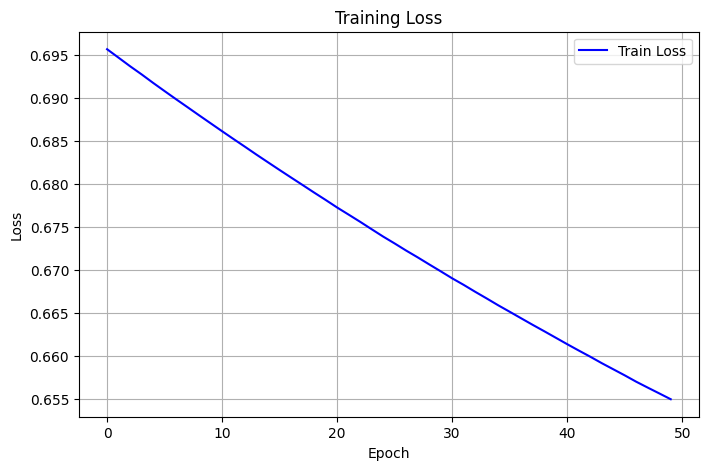

In [36]:
plot = LossPlot()

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = []
    for inputs, labels in data.train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        # print statistics
    plot.update(sum(running_loss) / len(running_loss))

In [38]:
model.eval()

example = torch.tensor(
    [
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
    ]
).float()

logits = model(example.unsqueeze(0))[0]
probs = torch.sigmoid(logits)
preds = (probs > 0.5).int()
preds.reshape((4, 4))

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 1]], dtype=torch.int32)

In [55]:
pred_results: list[bool] = []

for val_inputs, val_labels in data.val_loader:
    logits = model(val_inputs)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int()
    for val_input, pred, val_label in zip(val_inputs, preds, val_labels):
        if torch.equal(pred, val_label):
            print(val_input.int())
            print(pred.reshape(SHAPE))
            print(val_label.reshape(SHAPE).int())

tensor([[0, 0, 0, 0],
        [1, 0, 1, 1],
        [0, 0, 0, 0],
        [1, 1, 0, 1]], dtype=torch.int32)
tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 0]], dtype=torch.int32)
tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [1, 0, 0, 0]], dtype=torch.int32)
